<a href="https://colab.research.google.com/github/solislemuslab/dna-nn-theory/blob/master/scripts/lstm_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference
- [Step-by-step understanding LSTM Autoencoder layers](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352)
- Hands-On Machine Learning, Chapter 17, Recurrent Autoencoders
- [Time-series forecasting with LSTM autoencoders](https://www.kaggle.com/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders)

In [1]:
!pip install -q biopython

In [2]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data -o splice.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  311k  100  311k    0     0  1271k      0 --:--:-- --:--:-- --:--:-- 1271k


In [3]:
from itertools import product

from Bio import SeqIO
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

In [4]:
d = {'EI': 0, 'IE': 1, 'N': 2}

DATA_PATH = 'splice.data'

data = pd.read_csv(DATA_PATH, header=None, sep=',\\W*', engine='python',
                   usecols=[0, 2])
data.columns = ['class', 'sequence']
for old, new in zip('NDSR', 'ATCG'):
    data['sequence'] = data['sequence'].str.replace(old, new)
data['class'] = data['class'].map(lambda y: d[y])
data.head()

,class,sequence
0,0,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,0,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,0,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,0,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,0,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


In [5]:
vocab = [' '.join(p) for p in product('ACGT', repeat=1)]
vectorize_layer = keras.layers.experimental.preprocessing.TextVectorization(
    standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
vectorize_layer.adapt(vocab)

def vectorize_text(x):
    x_index = tf.subtract(vectorize_layer(x), 2)
    return x_index, x_index

In [6]:
x, y = data['sequence'].to_numpy(), data['class'].to_numpy()
train_ds = Dataset.from_tensor_slices(x).map(vectorize_text).batch(32)

In [7]:
keras.backend.clear_session()

time_steps = 60
latent_size = 256

encoder = keras.Sequential([
    keras.Input(shape=(time_steps,)),
    keras.layers.Embedding(time_steps, 256),
    keras.layers.LSTM(latent_size, activation='tanh', return_sequences=False),
])

decoder = keras.Sequential([
    keras.Input(shape=(latent_size)),
    keras.layers.RepeatVector(time_steps),
    keras.layers.LSTM(256, activation='tanh', return_sequences=True),
    keras.layers.Dense(4, activation='softmax')
])

model = keras.Sequential([encoder, decoder])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256)               540672    
_________________________________________________________________
sequential_1 (Sequential)    (None, 60, 4)             526340    
Total params: 1,067,012
Trainable params: 1,067,012
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [9]:
history = model.fit(train_ds, epochs=400, verbose=0)

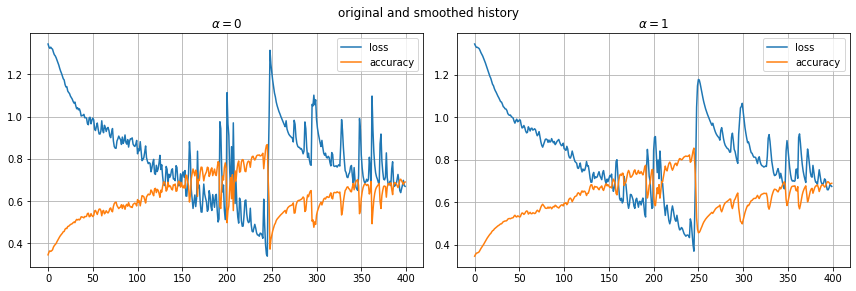

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

alpha = 1
df = pd.DataFrame(history.history)
df_ewa = df.ewm(com=alpha).mean()
df.plot(ax=ax0).grid()
df_ewa.plot(ax=ax1).grid()
ax0.set_title(rf'$\alpha=0$')
ax1.set_title(rf'$\alpha={alpha}$')
fig.suptitle('original and smoothed history', y=1)
plt.tight_layout()
plt.show()

In [15]:
'%.4f' % max(history.history['accuracy'])

'0.8672'